<a href="https://colab.research.google.com/github/mldmort/Mortazavi2021_B6B10/blob/main/Colab_Notebooks/B10specific_SNPs_MGI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# To run this script

---
Upload the files `speedseqsnp30x_merged_realigned_region_snp_no_Het_B10Spec_HOTSPOTS.bed` and `MGI_SNP_ALL_HOTSPOTS.txt` from [here](https://drive.google.com/drive/u/1/folders/1g6WIabQRq3H0IpUBDZSswbRIbpRDYjY6) into the content folder of this page.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import MaxNLocator

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (9,10,11,12,14,15,16,18,21,23,25,27,32,34,37,49,52,62,63,65,66,67,74,76) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


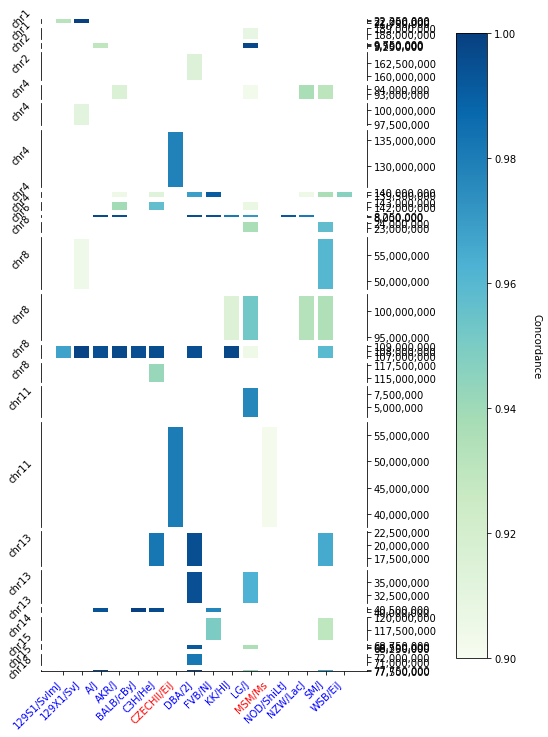

In [6]:
### read B10 specific SNPs in the hotspots
snp_b10Spec_file = 'speedseqsnp30x_merged_realigned_region_snp_no_Het_B10Spec_HOTSPOTS.bed'
snp_b10Spec_data = pd.read_table(snp_b10Spec_file, header=None, sep='\t')
snp_b10Spec_data.columns = ['chrom', 'pos', 'ref', 'alt']
snp_id_list = ['_'.join((x[0][3:], x[1])) for x in zip(snp_b10Spec_data['chrom'].map(str), snp_b10Spec_data['pos'].map(str))]
snp_b10Spec_data['snp_id'] = snp_id_list
#print('snp_b10Spec_data:')
#print(snp_b10Spec_data)

### read MGI SNPs in the hotspots
MGI_file = 'MGI_SNP_ALL_HOTSPOTS.txt'
MGI_data = pd.read_table(MGI_file, header=0, index_col=None, sep='\t')
#print('MGI_data:')
#print(MGI_data)
columns = MGI_data.columns.tolist()
columns[0] = 'rs_id'
columns[1] = 'chrom'
columns[2] = 'pos'
columns[3] = 'MGI_id'
columns[4] = 'Gene_Sym'
columns[5] = 'Category'
columns[6] = 'var_type'
columns[7] = 'alleles'
columns[-1] = 'None'
out_strains = columns[8:-1]

MGI_data.columns = columns
MGI_data.drop(['MGI_id', 'Gene_Sym', 'Category'], inplace=True, axis=1)
MGI_data.drop_duplicates(inplace=True)
MGI_snp_id_list = ['_'.join(x) for x in zip(MGI_data['chrom'].map(str), MGI_data['pos'].map(str))]
MGI_data['MGI_snp_id'] = MGI_snp_id_list
#print('MGI_data:')
#print(MGI_data)

### find common SNPs
snp_b10Spec_data_select = snp_b10Spec_data.loc[snp_b10Spec_data.snp_id.isin(MGI_data.MGI_snp_id)]
#print('snp_b10Spec_data_select:')
#print(snp_b10Spec_data_select)

### find common SNPs
MGI_data_select = MGI_data.loc[MGI_data.MGI_snp_id.isin(snp_b10Spec_data_select.snp_id)]
#print('MGI_data_select:')
#print(MGI_data_select)

### merge the two dataframes
snp_b10Spec_data_select_merge = snp_b10Spec_data_select.merge(MGI_data_select, left_on='snp_id', right_on='MGI_snp_id')
#print('snp_b10Spec_data_select_merge:')
#print(snp_b10Spec_data_select_merge)

### These are hotspot intervals
chr_segs = [('chr1', 0, 25e6),
            ('chr1', 175e6, 190e6),
            ('chr2', 0, 10e6),
            ('chr2', 155e6, 165e6),
            ('chr4', 0, 90e6),
            ('chr4', 90e6, 96e6),
            ('chr4', 96e6, 110e6),
            ('chr4', 110e6, 120.5e6),
            ('chr4', 120.5e6, 124.5e6),
            ('chr4', 124.5e6, 137.5e6),
            ('chr4', 137.5e6, 140.5e6),
            ('chr4', 140.5e6, 150e6),
            ('chr6', 7.8e6, 8.8e6),
            ('chr8', 0, 40e6),
            ('chr8', 40e6, 80e6),
            ('chr8', 80e6, 104.5e6),
            ('chr8', 104.5e6, 111e6),
            ('chr8', 111e6, 120e6),
            ('chr9', 65e6, 70e6),
            ('chr11', 0, 20e6),
            ('chr11', 20e6, 60e6),
            ('chr13', 0, 25e6),
            ('chr13', 25e6, 38e6),
            ('chr13', 38e6, 45e6),
            ('chr14', 115e6, 120e6),
            ('chr15', 65e6, 70e6),
            ('chr15', 70e6, 75e6),
            ('chr18', 77.45e6, 77.75e6)]

for chr_seg in chr_segs:
    chrom = chr_seg[0]
    start = chr_seg[1]
    end = chr_seg[2]
    #print('+'*60)
    #print('chrom, start, end')
    #print(chrom, start, end)
    concord_df = pd.DataFrame(index=out_strains, columns=['overlap', 'common', 'concord'])

    df_select = snp_b10Spec_data_select_merge.loc[(snp_b10Spec_data_select_merge.chrom_x==chrom) & (snp_b10Spec_data_select_merge.pos_x>start) & (snp_b10Spec_data_select_merge.pos_x<end)]
    #print('df_select:')
    #print(df_select)
    #print('# SNPs:')
    #print(df_select.shape[0])
    my_alts = df_select.alt
    for strain in out_strains:
        this_alts = df_select[strain]
        this_not_nan = df_select[strain].notna()
        this_not_nan_sum = this_not_nan.sum()
        if this_not_nan_sum==0:
            concord_df.loc[strain, 'overlap'] = 0
            concord_df.loc[strain, 'common'] = 0
            concord_df.loc[strain, 'concord'] = 0
            continue
        common_allel = my_alts==this_alts
        common_allel_sum = common_allel.sum()
        concord = float(common_allel_sum) / float(this_not_nan_sum)
        concord_df.loc[strain, 'overlap'] = this_not_nan_sum
        concord_df.loc[strain, 'common'] = common_allel_sum
        concord_df.loc[strain, 'concord'] = concord

    concord_df.sort_values(by=['concord'], ascending=False, inplace=True)

    snp_thr = 300
    con_thr = 0.9

    concord_df = concord_df.loc[(concord_df.overlap > snp_thr) & (concord_df.concord > con_thr)]
    #print('concord_df:')
    #print(concord_df)
    hits_strains = ';'.join(concord_df.index.tolist())
    hits_ovrs = ';'.join(concord_df.overlap.map(str).tolist())
    hits_cons = ';'.join(concord_df.concord.map(str).tolist())
    #print(hits_strains)
    #print(hits_ovrs)
    #print(hits_cons)
    if (not concord_df.empty):
        snp_b10Spec_data_select_merge.loc[df_select.index.tolist(), 'hits_strains'] = hits_strains
        snp_b10Spec_data_select_merge.loc[df_select.index.tolist(), 'hits_ovrs'] = hits_ovrs
        snp_b10Spec_data_select_merge.loc[df_select.index.tolist(), 'hits_cons'] = hits_cons
        #print('snp_b10Spec_data_select_merge:')
        #print(snp_b10Spec_data_select_merge)

#print('snp_b10Spec_data_select_merge:')
#print(snp_b10Spec_data_select_merge)

########## plot ##########
hit_data = snp_b10Spec_data_select_merge
hit_data_sel = hit_data.loc[hit_data.hits_strains.notna()]
#print('hit_data_sel:')
#print(hit_data_sel)
hits_strains_set = set()
for x in hit_data_sel.hits_strains.tolist():
    hits_strains_set.update(x.split(';'))
hits_strains_list = sorted(list(hits_strains_set))
#print('len(hits_strains_set):')
#print(len(hits_strains_set))
#print('hits_strains_set:')
#print(hits_strains_set)
#print('hits_strains_list:')
#print(hits_strains_list)

data_segment_dict = {}
chroms = ['chr1', 'chr2', 'chr4', 'chr6', 'chr8', 'chr9', 'chr11', 'chr13', 'chr14', 'chr15', 'chr18']
for iseg, chr_seg in enumerate(chr_segs):
    data_segment_list = []
    chrom = chr_seg[0]
    start = chr_seg[1]
    end = chr_seg[2]
    #print('+'*60)
    #print('chrom, start, end')
    #print(chrom, start, end)
    df_select = hit_data_sel.loc[(hit_data_sel.chrom_x==chrom) & (hit_data_sel.pos_x>start) & (hit_data_sel.pos_x<end)]
    if (not df_select.empty):
        pos_min = df_select.pos_x.min()
        pos_max = df_select.pos_x.max()
        height = pos_max - pos_min
        hits_strains = df_select.iloc[0]['hits_strains'].split(';')
        hits_ovrs = str(df_select.iloc[0]['hits_ovrs']).split(';')
        hits_cons = str(df_select.iloc[0]['hits_cons']).split(';')

        for ix, strain in enumerate(hits_strains):
            ovr = float(hits_ovrs[ix])
            con = float(hits_cons[ix])
            my_dict = {'strain':strain, 'pos_min':pos_min, 'pos_max':pos_max, 'height':height, 'concord':con, 'ovr':ovr}
            data_segment_list.append(my_dict)
        key = chrom+'_'+str(iseg)
        data_segment_dict[key] = data_segment_list

strains_to_num = {s:i for i,s in enumerate(hits_strains_list)}

H = 1.
height_ratios = []
for key, data_segment_list in data_segment_dict.items():
    height_ratios.append(data_segment_list[0]['height']/H)

nplot = len(data_segment_dict.keys())
fig, axs = plt.subplots(nplot, 1, sharex=True, gridspec_kw={'height_ratios':height_ratios})
fig.set_size_inches(8,12)
iplot = 0
for key, data_segment_list in data_segment_dict.items():
    chrom, iseg = key.split('_')
    my_cmap = plt.cm.get_cmap('GnBu')
    data_color = [(x['concord']-0.9)/0.1 for x in data_segment_list]
    heights = [0. for x in hits_strains_list]
    bottoms = [0. for x in hits_strains_list]
    data_color = [0. for x in hits_strains_list]
    for x in data_segment_list:
        st = x['strain']
        ist = strains_to_num[st]
        heights[ist] = x['height']/H
        bottoms[ist] = x['pos_min']/H
        data_color[ist] = (x['concord']-0.9)/0.1
    bottom_min = np.array(bottoms)[np.array(bottoms)>0].min()
    for ib, bot in enumerate(bottoms):
        if bot==0:
            bottoms[ib] = bottom_min
    colors = my_cmap(data_color)
    bars = axs[iplot].bar(hits_strains_list, height=heights, bottom=bottoms, color=colors)
    axs[iplot].ticklabel_format(style='plain', axis='y')
    axs[iplot].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.setp(axs[iplot].get_yticklabels(), rotation=45, fontsize=8)
    axs[iplot].set_ylabel(chrom, rotation=45)
    axs[iplot].yaxis.set_label_coords(-0.05,0.5)
    axs[iplot].yaxis.tick_right()
    iplot += 1

plt.xticks(rotation=45, ha='right')
sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0.9,1.))
sm.set_array([])
cbar = plt.colorbar(sm, ax=axs.ravel().tolist(), fraction=0.07, pad=0.2)
cbar.set_label('Concordance', rotation=270,labelpad=25)
for i, a in enumerate(axs):
    a.spines["top"].set_visible(False)
    if i!=(len(axs)-1):
        a.spines["bottom"].set_visible(False)
        a.get_xaxis().set_visible(False)

my_colors = ['b', 'b', 'b', 'b', 'b', 'b', 'r', 'b', 'b', 'b', 'b', 'r', 'b', 'b', 'b', 'b']
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
plt.show()